Abstractive summarization, SEQ2SEQ

In [1]:
import numpy as np  
import pandas as pd 
import re
from nltk.corpus import stopwords
pd.set_option("display.max_colwidth", 200)
from keras.preprocessing.text import Tokenizer 
from keras.utils import pad_sequences

from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

Importing data

In [ ]:
# # https://huggingface.co/datasets/cnn_dailymail
# import datasets
# dataset = datasets.load_dataset("cnn_dailymail", '3.0.0')
# lst_dics = [dic for dic in dataset["train"]]

# dtf = pd.DataFrame(lst_dics).rename(columns={"article":"text", "highlights":"y"})[["text","y"]].head(20000)

# dtf.to_csv("data_summary.csv", index=False)


In [3]:
data=pd.read_csv("data_summary.csv")

In [4]:
data.head()

,text,y
0,"LONDON, England (Reuters) -- Harry Potter star Daniel Radcliffe gains access to a reported £20 million ($41.1 million) fortune as he turns 18 on Monday, but he insists the money won't cast a spell...",Harry Potter star Daniel Radcliffe gets £20M fortune as he turns 18 Monday .\nYoung actor says he has no plans to fritter his cash away .\nRadcliffe's earnings from first five Potter films have be...
1,"Editor's note: In our Behind the Scenes series, CNN correspondents share their experiences in covering news and analyze the stories behind the events. Here, Soledad O'Brien takes users inside a ja...","Mentally ill inmates in Miami are housed on the ""forgotten floor""\nJudge Steven Leifman says most are there as a result of ""avoidable felonies""\nWhile CNN tours facility, patient shouts: ""I am the..."
2,"MINNEAPOLIS, Minnesota (CNN) -- Drivers who were on the Minneapolis bridge when it collapsed told harrowing tales of survival. ""The whole bridge from one side of the Mississippi to the other just ...","NEW: ""I thought I was going to die,"" driver says .\nMan says pickup truck was folded in half; he just has cut on face .\nDriver: ""I probably had a 30-, 35-foot free fall""\nMinnesota bridge collaps..."
3,"WASHINGTON (CNN) -- Doctors removed five small polyps from President Bush's colon on Saturday, and ""none appeared worrisome,"" a White House spokesman said. The polyps were removed and sent to the ...","Five small polyps found during procedure; ""none worrisome,"" spokesman says .\nPresident reclaims powers transferred to vice president .\nBush undergoes routine colonoscopy at Camp David ."
4,"(CNN) -- The National Football League has indefinitely suspended Atlanta Falcons quarterback Michael Vick without pay, officials with the league said Friday. NFL star Michael Vick is set to appea...","NEW: NFL chief, Atlanta Falcons owner critical of Michael Vick's conduct .\nNFL suspends Falcons quarterback indefinitely without pay .\nVick admits funding dogfighting operation but says he did n..."


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    20000 non-null  object
 1   y       20000 non-null  object
dtypes: object(2)
memory usage: 312.6+ KB


In [6]:
stop_words = set(stopwords.words('english')) 
stop_words

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

Cleaning

In [7]:
# constructing cleaning function

def text_cleaner(text):
    newString = text.lower()
    newString = re.sub(r'\([^)]*\)', '', newString) # replacing these regular expressions with blank spaces
    newString = re.sub('"','', newString)
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    
    tokens = [w for w in newString.split() if not w in stop_words]
    
    long_words=[]
    
    for i in tokens:
        if len(i)>=3:                  #removing short words
            long_words.append(i)   
    return (" ".join(long_words)).strip()


In [8]:
# cleaning articles
cleaned_text = []
for t in data['text']:
    cleaned_text.append(text_cleaner(t))

In [9]:
# cleaning summaries
cleaned_summary = []    
for t in data['y']:
    cleaned_summary.append(text_cleaner(t))

In [10]:
# adding cleaned data to DataFrame
data['cleaned_text']=cleaned_text
data['cleaned_summary']=cleaned_summary

In [11]:
data.head()

,text,y,cleaned_text,cleaned_summary
0,"LONDON, England (Reuters) -- Harry Potter star Daniel Radcliffe gains access to a reported £20 million ($41.1 million) fortune as he turns 18 on Monday, but he insists the money won't cast a spell...",Harry Potter star Daniel Radcliffe gets £20M fortune as he turns 18 Monday .\nYoung actor says he has no plans to fritter his cash away .\nRadcliffe's earnings from first five Potter films have be...,london england harry potter star daniel radcliffe gains access reported million fortune turns monday insists money cast spell daniel radcliffe harry potter harry potter order phoenix disappointmen...,harry potter star daniel radcliffe gets fortune turns monday young actor says plans fritter cash away radcliffe earnings first five potter films held trust fund
1,"Editor's note: In our Behind the Scenes series, CNN correspondents share their experiences in covering news and analyze the stories behind the events. Here, Soledad O'Brien takes users inside a ja...","Mentally ill inmates in Miami are housed on the ""forgotten floor""\nJudge Steven Leifman says most are there as a result of ""avoidable felonies""\nWhile CNN tours facility, patient shouts: ""I am the...",editor note behind scenes series cnn correspondents share experiences covering news analyze stories behind events soledad brien takes users inside jail many inmates mentally ill inmate housed forg...,mentally ill inmates miami housed forgotten floor judge steven leifman says result avoidable felonies cnn tours facility patient shouts son president leifman says system unjust fighting change
2,"MINNEAPOLIS, Minnesota (CNN) -- Drivers who were on the Minneapolis bridge when it collapsed told harrowing tales of survival. ""The whole bridge from one side of the Mississippi to the other just ...","NEW: ""I thought I was going to die,"" driver says .\nMan says pickup truck was folded in half; he just has cut on face .\nDriver: ""I probably had a 30-, 35-foot free fall""\nMinnesota bridge collaps...",minneapolis minnesota drivers minneapolis bridge collapsed told harrowing tales survival whole bridge one side mississippi completely gave way fell way survivor gary babineau told cnn probably foo...,new thought going die driver says man says pickup truck folded half cut face driver probably foot free fall minnesota bridge collapsed rush hour wednesday
3,"WASHINGTON (CNN) -- Doctors removed five small polyps from President Bush's colon on Saturday, and ""none appeared worrisome,"" a White House spokesman said. The polyps were removed and sent to the ...","Five small polyps found during procedure; ""none worrisome,"" spokesman says .\nPresident reclaims powers transferred to vice president .\nBush undergoes routine colonoscopy at Camp David .",washington doctors removed five small polyps president bush colon saturday none appeared worrisome white house spokesman said polyps removed sent national naval medical center bethesda maryland ro...,five small polyps found procedure none worrisome spokesman says president reclaims powers transferred vice president bush undergoes routine colonoscopy camp david
4,"(CNN) -- The National Football League has indefinitely suspended Atlanta Falcons quarterback Michael Vick without pay, officials with the league said Friday. NFL star Michael Vick is set to appea...","NEW: NFL chief, Atlanta Falcons owner critical of Michael Vick's conduct .\nNFL suspends Falcons quarterback indefinitely without pay .\nVick admits funding dogfighting operation but says he did n...",national football league indefinitely suspended atlanta falcons quarterback michael vick without pay officials league said friday nfl star michael vick set appear court monday judge final say plea...,new nfl chief atlanta falcons owner critical michael vick conduct nfl suspends falcons quarterback indefinitely without pay vick admits funding dogfighting operation says gamble vick due federal c...


In [12]:
# adding START and END special tokens at the beginning and end of the summary
data['cleaned_summary'] = data['cleaned_summary'].apply(lambda x : '_START_ '+ x + ' _END_')

In [15]:
data.head()

,text,y,cleaned_text,cleaned_summary
0,"LONDON, England (Reuters) -- Harry Potter star Daniel Radcliffe gains access to a reported £20 million ($41.1 million) fortune as he turns 18 on Monday, but he insists the money won't cast a spell...",Harry Potter star Daniel Radcliffe gets £20M fortune as he turns 18 Monday .\nYoung actor says he has no plans to fritter his cash away .\nRadcliffe's earnings from first five Potter films have be...,london england harry potter star daniel radcliffe gains access reported million fortune turns monday insists money cast spell daniel radcliffe harry potter harry potter order phoenix disappointmen...,_START_ harry potter star daniel radcliffe gets fortune turns monday young actor says plans fritter cash away radcliffe earnings first five potter films held trust fund _END_
1,"Editor's note: In our Behind the Scenes series, CNN correspondents share their experiences in covering news and analyze the stories behind the events. Here, Soledad O'Brien takes users inside a ja...","Mentally ill inmates in Miami are housed on the ""forgotten floor""\nJudge Steven Leifman says most are there as a result of ""avoidable felonies""\nWhile CNN tours facility, patient shouts: ""I am the...",editor note behind scenes series cnn correspondents share experiences covering news analyze stories behind events soledad brien takes users inside jail many inmates mentally ill inmate housed forg...,_START_ mentally ill inmates miami housed forgotten floor judge steven leifman says result avoidable felonies cnn tours facility patient shouts son president leifman says system unjust fighting ch...
2,"MINNEAPOLIS, Minnesota (CNN) -- Drivers who were on the Minneapolis bridge when it collapsed told harrowing tales of survival. ""The whole bridge from one side of the Mississippi to the other just ...","NEW: ""I thought I was going to die,"" driver says .\nMan says pickup truck was folded in half; he just has cut on face .\nDriver: ""I probably had a 30-, 35-foot free fall""\nMinnesota bridge collaps...",minneapolis minnesota drivers minneapolis bridge collapsed told harrowing tales survival whole bridge one side mississippi completely gave way fell way survivor gary babineau told cnn probably foo...,_START_ new thought going die driver says man says pickup truck folded half cut face driver probably foot free fall minnesota bridge collapsed rush hour wednesday _END_
3,"WASHINGTON (CNN) -- Doctors removed five small polyps from President Bush's colon on Saturday, and ""none appeared worrisome,"" a White House spokesman said. The polyps were removed and sent to the ...","Five small polyps found during procedure; ""none worrisome,"" spokesman says .\nPresident reclaims powers transferred to vice president .\nBush undergoes routine colonoscopy at Camp David .",washington doctors removed five small polyps president bush colon saturday none appeared worrisome white house spokesman said polyps removed sent national naval medical center bethesda maryland ro...,_START_ five small polyps found procedure none worrisome spokesman says president reclaims powers transferred vice president bush undergoes routine colonoscopy camp david _END_
4,"(CNN) -- The National Football League has indefinitely suspended Atlanta Falcons quarterback Michael Vick without pay, officials with the league said Friday. NFL star Michael Vick is set to appea...","NEW: NFL chief, Atlanta Falcons owner critical of Michael Vick's conduct .\nNFL suspends Falcons quarterback indefinitely without pay .\nVick admits funding dogfighting operation but says he did n...",national football league indefinitely suspended atlanta falcons quarterback michael vick without pay officials league said friday nfl star michael vick set appear court monday judge final say plea...,_START_ new nfl chief atlanta falcons owner critical michael vick conduct nfl suspends falcons quarterback indefinitely without pay vick admits funding dogfighting operation says gamble vick due f...


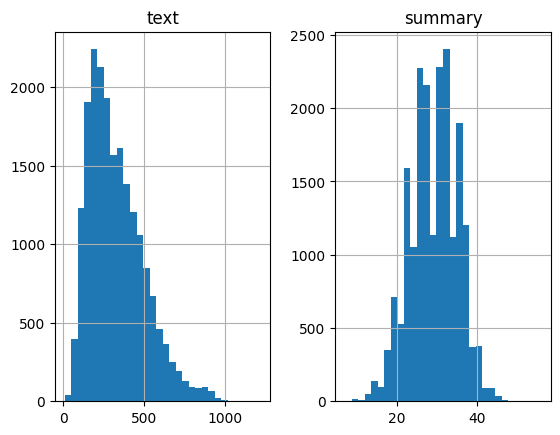

In [17]:
# for deciding on maximum length of sequences

import matplotlib.pyplot as plt
text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in data['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in data['cleaned_summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})
length_df.hist(bins = 30)
plt.show()

Based on the charts above we can set:

In [18]:
max_len_text = 500
max_len_summary = 10

In [19]:
# splitting for train and test
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(data['cleaned_text'],data['cleaned_summary'],test_size=0.1,random_state=0,shuffle=True)

Preparing the Tokenizer

In [20]:
# prepare a tokenizer for articles on training data
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_tr))


In [21]:

# convert text sequences into integer sequences
x_tr    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val   =   x_tokenizer.texts_to_sequences(x_val)


In [22]:

# padding zero up to maximum length
x_tr    =   pad_sequences(x_tr,  maxlen=max_len_text, padding='post') 
x_val   =   pad_sequences(x_val, maxlen=max_len_text, padding='post')

x_voc_size   =  len(x_tokenizer.word_index) +1


Summaries tokenizer

In [23]:
#preparing a tokenizer for summary on training data 
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_tr))

#convert summary sequences into integer sequences
y_tr    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr, maxlen=max_len_summary, padding='post')
y_val   =   pad_sequences(y_val, maxlen=max_len_summary, padding='post')

y_voc_size  =   len(y_tokenizer.word_index) +1

Model building part <br>
<hr>
Here, we are building a 3 stacked LSTM for the encoder:

In [24]:
from keras import backend as K 
K.clear_session() 
latent_dim = 500 


In [27]:
# Encoder 
encoder_inputs = Input(shape=(max_len_text,)) 
enc_emb = Embedding(x_voc_size, latent_dim,trainable=True)(encoder_inputs) 

#LSTM 1 
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb) 

#LSTM 2 
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1) 

#LSTM 3 
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True) 
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2) 

# Set up the decoder. 
decoder_inputs = Input(shape=(None,)) 
dec_emb_layer = Embedding(y_voc_size, latent_dim,trainable=True) 
dec_emb = dec_emb_layer(decoder_inputs) 

#LSTM using encoder_states as initial state
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True) 
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c]) 


In [28]:
from attention import AttentionLayer

In [29]:
#Attention Layer
attn_layer = AttentionLayer(name='attention_layer') 
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs]) 

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [30]:

# Concat attention output and decoder LSTM output 
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#Dense layer
decoder_dense = TimeDistributed(Dense(y_voc_size, activation='softmax')) 
decoder_outputs = decoder_dense(decoder_concat_input) 

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs) 
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 500)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 500, 500)     49561000    ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 500, 500),   2002000     ['embedding[0][0]']              
                                 (None, 500),                                                     
                                 (None, 500)]                                                     
                                                                                              

In [31]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [32]:

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

<hr>

Model training

In [38]:
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:])

  9/563 [..............................] - ETA: 7:50:58 - loss: 10.3113

In [33]:
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=50,callbacks=[es],batch_size=512, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Epoch 1/50


ResourceExhaustedError: Graph execution error:

OOM when allocating tensor with shape[512,500] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu
	 [[{{node TensorArrayUnstack/TensorListFromTensor}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

	 [[model/lstm_2/PartitionedCall]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_13110]